## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Project review date/time: Monday 1 April 2019 11am ET
* Instructor name: Jeff Herman
* Blog post URL:


"Database for The Scratched Voices Begging to be Heard: The Graffiti of Pompeii and Today"

by Alexa Rose

https://core.tdar.org/dataset/445837/database-for-the-scratched-voices-begging-to-be-heard-the-graffiti-of-pompeii-and-today

<a id = 'top'></a>

# Contents
- Libraries and helper functions
- [A first look at the data](#obtain)
- [Cleaning the raw data](#scrub)
- [Exploratory data analysis](#explore)
 - [Character count and imperatives](#character_imperative)
 - [How good are the categories?](#prelim_model)
 - [Detour: improving the categories](#detour_cat)
- Modeling
 - [Model \#1](#model1)
 - [Model \#2](#model2)
 - [Model \#3](#model3)
- [Conclusions](#concl)

# Libraries and helper functions

In [1]:
import pandas as pd #For working with DataFrames
import matplotlib.pyplot as plt #For visualizing plots
import numpy as np #For mathematical operations
import random                   #for generating random numbers for train/test split
import copy                     #for making deep copies of mutable objects
from pandasql import sqldf #for manipulating DataFrames with SQL style queries
#for dividing data into a training set and a testing set
from sklearn.model_selection import train_test_split 
#For building regular logistic regression models
from sklearn.linear_model import LogisticRegression
#To get accuracy, precision, recall, and F1 score (weighted accuracy) of a given confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#To view the accuracy metrics for a given confusion matrix
from sklearn.metrics import classification_report
#For building decision trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
#For scaling/normalizing, and for LabelEncoder and OneHotEncoder
from sklearn import preprocessing
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OneHotEncoder
#For visualizing decision trees:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
#For assessing accuracy of logistic regression or decision trees
from sklearn.metrics import confusion_matrix 
import itertools #To iteratively append labels to cells in a confusion matrox


In [2]:
import time

In [ ]:
#Thing for separating values by hyphen slash etc



In [ ]:
#Thing for getting indexes and filling values maybe



In [38]:
#Tool for exploring categories of data
#Construct a dataframe to track incidence of key words
def keyword_matrix(orig_categories, keywords):
    
    '''
    A tool for exploring the incidence of certain key words within 
    a data set's categories/classes. It uses a Pandasql query to 
    get counts of a key word for each category in the data and
    constructs a one-row dataframe of the counts.
    
    Each key word's row gets appended to the previous rows in the 
    DataFrame.
    
    In this version, the data set to query is hard coded as 'df'.
    The category to search within is hard coded as
    'In English.'
    
    Parameters:
    
    orig_categories (list.) The categories in the data set to traverse.
    Each should correspond to a category/class in the data set.
    
    keywords (list.) The words to search for and count. If a single 
    word is sought, it can be passed as ['word']. Can't be multi-level,
    i.e. a list of lists.
    
    
    Returns: 
    
    keywords_df (pandas.core.frame.DataFrame.) The full DataFrame with
    the counts of all key words in all categories.
    '''
    
    #A list of category names for the df
    categories = copy.deepcopy(orig_categories)
    categories.insert(0, 'Key_Word')

    #list of columns to add to the query string. (Doesn't have 'Key Word.')
    cats = copy.deepcopy(orig_categories)

    #Instantiate an empty dataframe to hold results
    keywords_df = pd.DataFrame(columns = categories)

    #Build the dataframe
    for keyword in keywords:
        #Build query string.
        q = '''SELECT '{}' Key_Word,'''.format(keyword)
        #Build query string by iterating over list of columns
        #Simultaneously add the keyword str as many types as there are categories
        for cat in cats:
            q += ''' SUM(
                    CASE WHEN
                    [In English] LIKE '%{}%'
                    AND Category == '{}'
                    THEN 1 ELSE 0 END
                    ) {},
            '''.format(keyword, cat, cat)
        q = q[:-14]
        q += '''
        FROM df_raw;'''
        #Apply the query string with the given keyword to the df.
        results = pysqldf(q)
        #Concat the new row onto the df
        keywords_df = pd.concat([keywords_df, results])

    keywords_df.reset_index(inplace = True)
    keywords_df.drop(['index'], axis = 1, inplace = True)
    return keywords_df

In [42]:
#Fill values in a column conditionally
#Words sought can be a list or a single value
#Exact match or just 'appears in' can be specified
def write(df, words_sought, read_from, write_to, phrase, exact = False):
    '''
    A tool for changing the values of certain cells in a DataFrame under
    certain conditions. Looks for a given value, whetehr an exact or partial
    match, and then replaces the value of a given column in that row with a
    new given value. Can replace the very value that was sought or another in
    that row. The value sought can be a list or a single value.
    
    Parameters:
    
    df (pandas.core.frame.DataFrame.) The df to search for words and in which to
    write the new phrase.
    
    words_sought (list.) Key words to look for in the "read from" column. Can be a
    single value passed as ['value'].
    
    read_from (str.) The column in which to search for the words sought.
    
    write_to (str.) The column to write the new phrase into. Can be the same as 
    read_from.
    
    phrase (str, int, or float.) The phrase to be written into the cell.
    
    exact (bool.) Set to False by default. If True, looks for exact match (==)
    not just a partial match ("in.")
    
    Returns:
    
    Doesn't return a new object. Writes the new value into the DataFrame in place.
    Use with caution!
    '''
    
    #Iterate over each row in the given df
    for index in df.index:
        #If one of the given words is found in the given column
        if not exact:
            if any(word_sought in df.at[index, read_from] for word_sought in words_sought):
                #Write the new phrase to the other given column
                df.at[index, write_to] = phrase
        else: 
            #If the word sought matches the value of the cell
            if df.at[index, read_from] == words_sought:
                #Write the new phrase to the other given column
                df.at[index, write_to] = phrase

In [11]:
#Example function to visualize a confusion matrix without yellow brick
def plot_conf_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
#    if normalize:
#        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#        print("Matrix, normalized")
#    else:
#        print('Matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def draw_graph(clf):
    '''
    Visualizes a decision tree using GraphViz.
    
    Parameters:
    
    clf (DecisionTreeClassifier.) Must be already fit with data.
    
    Returns:
    
    image (graph.create_png().) Call the assigned variable to draw the image. 
    '''
    dot_data = StringIO()

    #Feeds from decision tree classifier instantiated above
    export_graphviz(clf, out_file=dot_data, filled=True, 
                    rounded=True,special_characters=True)

    #Create graph
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    image = graph.create_png()
    
    #Draw image
    return image

<a id = 'obtain'></a>

[(Back to top)](#top)

# A first look at the data

In [13]:
#Obtain the raw data
df_raw = pd.read_csv('graffiti.csv')

In [ ]:
df_raw.head(20)

In [ ]:
df_raw.info()

Columns to drop:

'found'
'org'?
'comments'?

Change 'Literacy' to integer before categorizing. Rename column.

Rename 'Image ' as 'Image'.

Categorical variables to transform: Reggio, Insula, Literacy, Context type specific, Context type general, Famous House (?), Socio-economic status


Null values to fill: Reggio, Insula, Entrance, Context type specific, Context type general, Famous House,

Target: 'Category'

<a id = 'scrub'></a>

[(Back to top)](#top)

# Cleaning the data

## Column by column

### 'CIL IV Pound sign'

In [14]:
df_raw['CIL IV #'] = df_raw['CIL IV #'].fillna(0)

### 'Reggio'

In [ ]:
df_raw['Reggio'].value_counts()

In [ ]:
print(df_raw['Reggio'].isna().sum())

In [15]:
#Fill NaN values
df_raw['Reggio'] = df_raw['Reggio'].fillna(0)
#Change 6_7 to 6
df_raw.at[994, 'Reggio'] = '6'
#Change data type to integer
df_raw['Reggio'] = df_raw['Reggio'].astype('float').astype('int')

Zero values can be filled later once more is known about the reggios.

### 'Insula'

In [ ]:
df_raw['Insula'].value_counts()

In [ ]:
df_raw['Insula'].value_counts().sum()

In [ ]:
df_raw['Insula'].isna().sum()

In [16]:
#Fill null values
df_raw['Insula'] = df_raw['Insula'].fillna(0)

#Replace the values with underscores
df_raw.at[985, 'Insula'] = '4'
df_raw.at[986, 'Insula'] = '4'
df_raw.at[983, 'Insula'] = '4'
df_raw.at[984, 'Insula'] = '4'
df_raw.at[988, 'Insula'] = '9'
df_raw.at[987, 'Insula'] = '8'
df_raw.at[982, 'Insula'] = '12'
df_raw.at[981, 'Insula'] = '1'

#Change data type to intger
df_raw['Insula'] = df_raw['Insula'].astype('float').astype('int')

### 'Entrance'

In [ ]:
df_raw['Entrance'].value_counts()

In [17]:
#Fill null values
df_raw['Entrance'] = df_raw['Entrance'].fillna('unknown')

#Replace all values with underscores or hyphens
#Dict to fill values from 'Entrance'
entrance_replacements = dict()
entrance_values = df_raw['Entrance'].value_counts()

#Iterate over Entrance values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in entrance_values.index:
        if '_' in index:
            index_split = index.split('_')
            entrance_replacements[index] = index_split[0]
        elif '-' in index:
            index_split = index.split('-')
            entrance_replacements[index] = index_split[0]
            
df_raw['Entrance'] = df_raw['Entrance'].replace(entrance_replacements)

#Change 'F' to 'f'
df_raw.at[661, 'Entrance'] = df_raw.at[661, 'Entrance'].lower()
#Change '4/5/' to '4'
df_raw.at[6, 'Entrance'] = '4'
#Replace 'I' and '?'
df_raw['Entrance'] = df_raw['Entrance'].replace({'I': 'i', '?': 'unknown'})

In [ ]:
df_raw['Entrance'].value_counts().shape

This is better, but it may have to be categorized.

### 'found?'

In [ ]:
df_raw['found?'].isna().sum()

In [18]:
#Can just be dropped
df_raw.drop(['found?'], axis = 1, inplace = True)

### 'In English'

In [ ]:
df_raw['In English'].isna().sum()

In [19]:
#Fill nulls so that they can be read
df_raw['In English'] = df_raw['In English'].fillna('')

#Rows with null values or unhelpful 'CHECK' values
blank_indexes = df_raw.index[df_raw['In English'] == '']
check_indexes = df_raw.index[df_raw['In English'] == '[CHECK]']

#Drop the empty rows. They aren't useful if they don't have the English text of the graffiti.
df_raw.drop(blank_indexes, inplace = True)
df_raw.drop(check_indexes, inplace = True)

### 'org. '

In [ ]:
df_raw['org. '].value_counts()[:10]

In [20]:
#Won't be useful here. Can be dropped.
df_raw.drop(['org. '], axis = 1, inplace = True)

### 'Literacy'

In [ ]:
df_raw['Literacy (1-3)'].value_counts()

In [ ]:
df_raw['Literacy (1-3)'].isna().sum()

In [21]:
#Rename column
df_raw = df_raw.rename(index=str, columns = {'Literacy (1-3)': 'Literacy'})

#Turn the few 1 values into 2s.
df_raw['Literacy'] = df_raw['Literacy'].replace({1.0: 2})

#Fill nulls
df_raw['Literacy'] = df_raw['Literacy'].fillna(2)

#Turn floats into integers
df_raw['Literacy'] = df_raw['Literacy'].astype('float').astype('int')

### 'In org. language'

In [ ]:
df_raw['In org. language'].value_counts().sum()

In [22]:
#Dropping for now
df_raw.drop(['In org. language'], axis = 1, inplace = True)

Not sure what to do with this at this point.

### 'Context type general'

In [ ]:
df_raw['Context type general'].value_counts()

In [ ]:
df_raw['Context type general'].isna().sum()

In [23]:
# No specific, no general, no reggio, insula
no_spec_no_gen = df_raw[df_raw['Context type specific'].isna() & df_raw['Context type general'].isna()]

no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)].shape

#Must drop the 43 rows that don't have a reggio, insula, specfic context or general context
to_drop = no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)]
df_raw.drop(to_drop.index, axis = 0, inplace = True)

#Maybe famous house can fill in for general context where it's missing?
famoushouse_nogen = df_raw[
    (df_raw['Famous House'].notna())
    & 
    (df_raw['Context type general'].isna())]

#Get indexes of all rows without a gen context but with a famous house
indexes = famoushouse_nogen.index

famoushouse_gencontexts = {
    'Praedia ': 'building',
    'Basilica': 'basilica',
    'House of': 'house',
    'house of': 'house',
    'Villa of': 'house',
    'Building': 'building',
    'near the Porta Vesuvio': 'necropolis',
    'Workshop': 'workshop'
}

#Replace gen context with the building type from its famous house
#Iterate over all the rows which have a famous house but lack a gen context
for index in indexes:
    #Iterate over the keys of famous houses
    for key, val in famoushouse_gencontexts.items():
        #If the row's famous house matches one from the dict
        if key in df_raw.at[index, 'Famous House']:
            #Fill missing gen context value with value from dict
            df_raw.at[index, 'Context type general'] = val
            
#Noticed that Bar of Sotericus has gen context of "house"
indexes = df_raw[df_raw['Famous House'] == 'Bar of Sotericus']['Context type general']
#Replace 'house' with 'bar' for these
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'bar'
    
#Noticed that 'Outside Porta Marina' had two NaN gen contexts to fix
#Will drop these because they're missing too many columns
df_raw.drop(['997', '998'], axis = 0, inplace = True)

#change all building types for spec context "workshop" to gen context "workshop"
indexes = df_raw[df_raw['Context type specific'] == 'workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Same for 'Workshop'
indexes = df_raw[df_raw['Context type specific'] == 'Workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Specific context "dining room" to general context "house"
indexes = df_raw[
    (df_raw['Context type specific'] == 'dining room')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'

#Spec context "shop" to general context "shop"
indexes = df_raw[
    (df_raw['Context type specific'] == 'shop')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'shop'
    
#Spec context "kitchen" to general context "house"    
indexes = df_raw[
    (df_raw['Context type specific'] == 'kitchen')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'    
    
#Add consistency to a few of the values
replacements = {'Baths': 'baths',
                'unit': 'apartment'}
df_raw['Context type general'] = df_raw['Context type general'].replace(replacements)

#Fill null values
df_raw['Context type general'] = df_raw['Context type general'].fillna('unknown')

#Changing the name of the column
df_raw = df_raw.rename(index=str, columns ={
              'Context type general': 'Building Type'})

### 'Context type specific'

In [ ]:
df_raw['Context type specific'].value_counts()

In [24]:
#Add consistency to values
replacements = {'façade': 'facade',
                'tablinium': 'tablinum',
                'Workshop': 'workshop'
                }

df_raw['Context type specific'] = df_raw['Context type specific'].replace(replacements)

#Fill null values
df_raw['Context type specific'] = df_raw['Context type specific'].fillna('unknown')

#Rename column
df_raw = df_raw.rename(index=str, columns ={'Context type specific': 'Position'})

### 'Famous House'

In [ ]:
df_raw['Famous House'].value_counts()[60:90]

In [ ]:
df_raw['Famous House'].isna().sum()

In [25]:
#Turn this column into a 0/1 for no/yes
indexes = df_raw[df_raw['Famous House'].notna()]

for index in indexes.index:
    df_raw.at[index, 'Famous House'] = 1
    
df_raw['Famous House'] = df_raw['Famous House'].fillna(0)

df_raw['Famous House'] = df_raw['Famous House'].astype('int')

### Target: 'Category'

In [ ]:
df_raw['Category'].value_counts()

In [26]:
#Replace all values with back slashes
#Dict to fill values from 'Category'
cat_replacements = dict()
cat_values = df_raw['Category'].value_counts()

#Iterate over Category values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first value from each pair
for index in cat_values.index:
        if '/' in index:
            index_split = index.split('/')
            cat_replacements[index] = index_split[0]
            
df_raw['Category'] = df_raw['Category'].replace(cat_replacements)

#This creates one instance of 'Political' with a space
df_raw['Category'] = df_raw['Category'].replace({'Political ': 'Political'})

#Fill null values
df_raw['Category'] = df_raw['Category'].fillna('unknown')

### 'Written by'

In [ ]:
df_raw['Written by'].value_counts()

In [27]:
#Fill null values first so str.contains can be used
df_raw['Written by'] = df_raw['Written by'].fillna('unknown')

#Clean up instances of ovid
ovids = df_raw[df_raw['Written by'].str.contains('Ovid', regex = False, case = False)]
for index in ovids.index:
    df_raw.at[index, 'Written by'] = 'Ovid'

#Clean up instances of virgil    
virgils = df_raw[df_raw['Written by'].str.contains('rgil', regex = False, case = False)]
for index in virgils.index:
    df_raw.at[index, 'Written by'] = 'Virgil'

#People who look like real writers as taken from value_counts    
writers = ['Antheros', 'Ennius', 'Epaphra', 
           'Virgil', 'Horace', 'Homer', 
           'Herodotus', 'Lucretius', 'Menander',
           'Ovid', 'poem', 'Propertius',
           'Salvius', 'Senica', 'Tibutinus']
                
#Iterate over all rows to replace values with 1 for a writer
#or zero for no writer
for index in df_raw.index:
    if any(writer in df_raw.at[index, 'Written by'] for writer in writers):
        df_raw.at[index, 'Written by'] = 1
    else:
        df_raw.at[index, 'Written by'] = 0
        
#Change name of column to 'Writer'
df_raw = df_raw.rename(index=str, columns ={'Written by': 'Writer'})

### 'Work', 'Meter', and 'Reptition'

In [28]:
#Change 'Work' to 0/1 no/yes
indexes = df_raw[df_raw['Work'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Work'] = 1    
df_raw['Work'] = df_raw['Work'].fillna(0)


#Change meter to 0/1 no/yes  
indexes = df_raw[df_raw['Meter'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Meter'] = 1    
df_raw['Meter'] = df_raw['Meter'].fillna(0)  

#Smush together Writer Work and Meter
indexes = df_raw[(df_raw['Writer'] == 0)
        &
        (
            (df_raw['Work'] == 1) 
            | 
            (df_raw['Meter'] == 1)
        )]

for index in indexes.index:
    df_raw.at[index, 'Writer'] = 1
    
#Reassign the category for these smushed together 
indexes = df_raw[df_raw['Writer'] == 1]

for index in indexes.index:
    df_raw.at[index, 'Category'] = 'Reference'

#Reset data type for Writer to int    
df_raw['Writer'] = df_raw['Writer'].astype('int')

#Meter, Work and Repetition can be dropped
df_raw.drop(['Meter', 'Work', 'Repetition'], axis = 1, inplace = True)

### 'Foreign language'

In [ ]:
df_raw['Foreign language'].value_counts()

In [ ]:
df_raw['Foreign language'].isna().sum()

In [29]:
#Can be dropped
df_raw.drop(['Foreign language'], axis = 1, inplace = True)

### 'Image '

In [30]:
#Get rid of the annoying space in the name
df_raw = df_raw.rename(index=str, columns = {'Image ': 'Image'})

#Fill nulls first so str.contains can be used
df_raw['Image'] = df_raw['Image'].fillna('none')

#Get all rows with gladiator in the image description
gladiators = df_raw[df_raw['Image'].str.contains('gladiator', regex = False, case = False)]

for index in gladiators.index:
    df_raw.at[index, 'Category'] = 'Violence'
    
#Drop the column
df_raw.drop(['Image'], axis = 1, inplace = True)

### 'Flohr Score'

In [ ]:
df_raw['Flohr Score'].value_counts()

In [31]:
#Replace all values with hyphens.
#Dict to fill values from 'Flohr Score'
flohr_replacements = dict()
flohr_values = df_raw['Flohr Score'].value_counts()

#Iterate over values to look for hyphen
#Make a dict with values to replace the - values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in flohr_values.index:
        if '-' in index:
            index_split = index.split('-')
            flohr_replacements[index] = index_split[0]
            
df_raw['Flohr Score'] = df_raw['Flohr Score'].replace(flohr_replacements)

#Get indexes for empty Flohr scores at each SES level
low = df_raw[
        (df_raw['Socio-economic status'] == 'low')
        &
        (df_raw['Flohr Score'].isna())   ]
med = df_raw[
        (df_raw['Socio-economic status'] == 'medium')
        &
        (df_raw['Flohr Score'].isna())]
high = df_raw[
        (df_raw['Socio-economic status'] == 'high')
        &
        (df_raw['Flohr Score'].isna())]

#Then fill null values with zeros so that means can be taken
df_raw['Flohr Score'] = df_raw['Flohr Score'].fillna(0.0)

#Change strings to floats
df_raw['Flohr Score'] = df_raw['Flohr Score'].astype('float')

#Get the average Flohr score for low SES rows
low_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'low']).mean()
#Get the average Flohr score for medium SES rows
med_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'medium']).mean()
#Get the average Flohr score high SES rows
high_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'high']).mean()

#Update the FLohr score for low SES rows
for index in low.index:
    df_raw.at[index, 'Flohr Score'] = low_avg
#Update the FLohr score for medium SES rows
for index in med.index:
    df_raw.at[index, 'Flohr Score'] = med_avg
#Update the FLohr score for high SES rows
for index in high.index:
    df_raw.at[index, 'Flohr Score'] = high_avg

### 'Socio-economic status'

In [ ]:
df_raw['Socio-economic status'].value_counts()

In [32]:
df_raw['Socio-economic status'] = df_raw['Socio-economic status'].fillna('medium')

### 'comments'

In [ ]:
df_raw['comments'].value_counts()


In [33]:
#interesting, further investigation could lead ot help with categorizing, but will drop for now
df_raw.drop(['comments'], axis = 1, inplace = True)

<a id = 'explore'></a>

[(Back to top)](#top)

# Exploratory data analysis

What is a reggio?

What is an insula?

From https://sites.google.com/site/ad79eruption/pompeii/map-of-pompeii

"Pompeii, however, has an additional level of numbering. It has been divided firstly into 9 regions (Regio), numbered in Roman numerals. Each of these regions contains several Insulae which are numbered 1, 2 3, etc. As with Herculaneum, each building within an insula has its own entrance number, again numbered 1, 2, 3 etc. For example, the House of Trebius Valens is labelled (Reg III, Ins 2, 1)."

In [ ]:
df_raw['Category'].value_counts()

<a id = 'character_imperative'></a>

### Adding a character count and imperative column

'Characters' will measure the length of the text of each graffito in English. 'Imperative' will count whether it has exclamation points or not.

In [34]:
#Create Characters and Imperative columns
for index in df_raw.index:
    df_raw.at[index, 'Characters'] = len(df_raw.at[index, 'In English'])
    if '!' in df_raw.at[index, 'In English']:
        df_raw.at[index, 'Imperative'] = 1
    else: 
        df_raw.at[index, 'Imperative'] = 0
df_raw['Characters'] = df_raw['Characters'].astype('int')
df_raw['Imperative'] = df_raw['Imperative'].astype('int')

<a id = 'prelim_model'></a>

### How good are the categories? Testing with a preliminary model: plain vanilla logistic regression

The data cleaning process made me suspicious that the given categories of the data aren't going to allow for good models. Let's build a plain vanilla logistic regression to see.

In [30]:
#Prepare the data and build a logistic regression classifier.

df = copy.deepcopy(df_raw)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)

In [31]:
logreg.fit(X_train, y_train)

#Generate predicted values for y to compare to real values
y_hat_train = logreg.predict(X_train)

#Now generate predicted values for the test data to compare
y_hat_test = logreg.predict(X_test)

#Create a confusion matrix with the training results
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix with the test results
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)

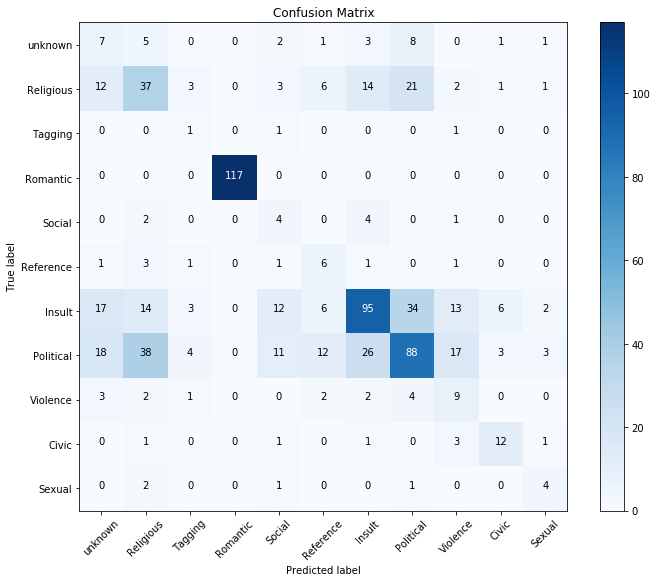

In [32]:
#Draw a figure
plt.figure(figsize = (10,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_train, classes = class_names)

In [33]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

             precision    recall  f1-score   support

    unknown       0.25      0.12      0.16        58
  Religious       0.37      0.36      0.36       104
    Tagging       0.33      0.08      0.12        13
   Romantic       1.00      1.00      1.00       117
     Social       0.36      0.11      0.17        36
  Reference       0.43      0.18      0.26        33
     Insult       0.47      0.65      0.55       146
  Political       0.40      0.56      0.47       156
   Violence       0.39      0.19      0.26        47
      Civic       0.63      0.52      0.57        23
     Sexual       0.50      0.33      0.40        12

avg / total       0.50      0.51      0.49       745



Discuss

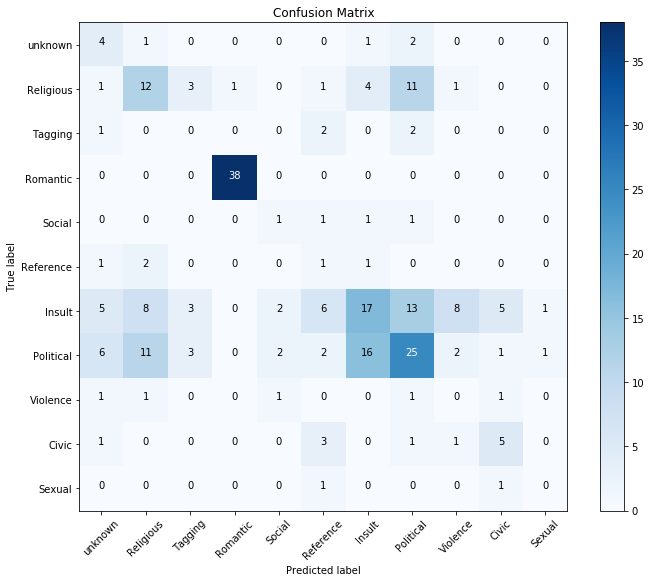

In [34]:
plt.figure(figsize = (10,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_test, classes = class_names)

In [35]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

             precision    recall  f1-score   support

    unknown       0.50      0.20      0.29        20
  Religious       0.35      0.34      0.35        35
    Tagging       0.00      0.00      0.00         9
   Romantic       1.00      0.97      0.99        39
     Social       0.25      0.17      0.20         6
  Reference       0.20      0.06      0.09        17
     Insult       0.25      0.42      0.31        40
  Political       0.36      0.45      0.40        56
   Violence       0.00      0.00      0.00        12
      Civic       0.45      0.38      0.42        13
     Sexual       0.00      0.00      0.00         2

avg / total       0.41      0.41      0.40       249



This model is almost useless! It only classifies 'Reference', 'Insult', and 'Violence.'

<a id = 'detour_cat'></a>

### Detour: improving the categories

I'm unhappy with the categories and think I can do better.

In [45]:
cat_counts = df_raw['Category'].value_counts()

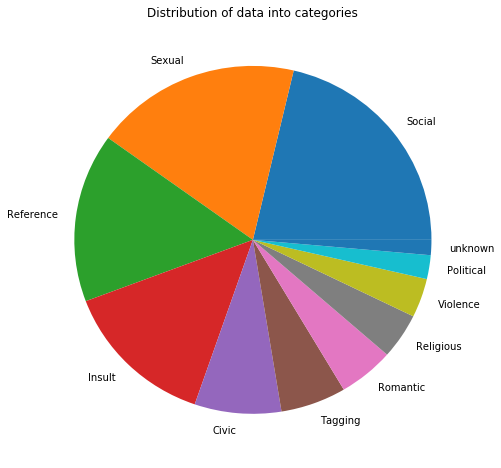

In [33]:
#COLROS ARE BROKEN

#colors_for_orig_cats = ['lavender', 'brown', 'yellow', 'blue', 'lightblue', 'purple',
#                       'maroon', 'red', 'pink', 'darkblue', 'gray']
fig = plt.figure(figsize = (8,8))
plt.pie(x = cat_counts, labels = cat_counts.index)
plt.title('Distribution of data into categories')
plt.show()

There are two problems to solve:

 1. Categories are imprecise. (What isn't "social"?)
 2. Data is unevenly distributed into these categories

Before I try to up- or down-sample I'd like to see if I can rearrange the data within the categories. I've browsed the English translations of the graffiti and have spotted some key words that I want to count the incidence of across the categories. This may suggest some more precise categories for the data. It may also allow for more even data distribution across categories.

In [35]:
#A new df for the reorganized categories
df_clean = copy.deepcopy(df_raw)

In [36]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

In [39]:
categories = list(df_raw['Category'].unique())

#Some possible new categories
#Hoping to draw values out from 'Social'
love = ['the girls', 'love', 'venus']
slave = ['servant', 'serve', 'slave']
emperor = ['Caesar', 'emperor', 'Nero']
gods = ['Jupiter', 'god', 'holy', 'pray']
greeting = ['bye', 'hello', 'goodbye', 'greetings']
glory = ['fight', 'mars','soldier', 'victor']
########## WARNING!! NSFW ################
lewd = ['bugger', 'cock', 'cunt', 'faggot', 'fuck', 'suck']
###########################################
blessing = ['best wishes', 'bravo',  'favor', 'favour', 'good luck', 'happy', 'smile']
curse = ['anger', 'beware', 'curse']
keyword_cats = [love, slave, emperor, gods, greeting, glory, lewd, blessing, curse]

#A list of all keywords
keywords = []
for cat in keyword_cats:
    for word in cat:
        keywords.append(word)
        
#Build a 'keyword matrix' with my custom function
#to show incidence of the above keywords in the 
#original categories of the data.
keywords_df = keyword_matrix(categories, keywords)

In [ ]:
keywords_df

In [40]:
#Opportunity to knock off many of the values from 'Social.'
keywords_df['Social'].sum()

139

In [43]:
#Categorize greetings, blessings, and curses as Hails 
#Hello, goodbye, good luck, go to hell)
hails = []
for words in [greeting, blessing, curse]:
    for word in words:
        hails.append(word)
write(df_clean, hails, 'In English', 'Category', 'Hail')

#Categorize references to emperors or slaves as Political
poli = []
for words in [emperor, slave]:
    for word in words:
        poli.append(word)
write(df_clean, poli, 'In English', 'Category', 'Political')

#Categorize glory words as Violence
write(df_clean, glory, 'In English', 'Category', 'Violence')
#Categorize lewd words as Lewd (new category)
write(df_clean, lewd, 'In English', 'Category', 'Lewd')
#Categorize love words as Romantic
write(df_clean, love, 'In English', 'Category', 'Romantic')
#Categorize gods words as Religious
write(df_clean, gods, 'In English', 'Category', 'Religious')

#Now:
#Combine 'Violence' and 'Political' into 'Glory'
write(df_clean, ['Violence', 'Political'], 'Category', 'Category', 'Glory')
#Combine 'Sexual' and 'Romantic' into 'Love'
write(df_clean, ['Sexual', 'Romantic'], 'Category', 'Category', 'Love')
#Combine 'unknown' and 'Tagging' into 'Civic'
write(df_clean, ['unknown', 'Tagging'], 'Category', 'Category', 'Civic')
#Combine 'Insult' with 'Hail' (They're both direct adresses)
write(df_clean, ['Insult'], 'Category', 'Category', 'Hail')
#Combine 'Religious' with 'Glory' (Politics, War, and Religion are all heady)
write(df_clean, ['Religious'], 'Category', 'Category', 'Glory')

#Now:
#Give the final categories jazzier names
replacements = {'Reference': 'Literature',
                'Social': 'Gossip',
                'Civic': 'Bulletin',
                'Religion': 'Gods'
                }
df_clean['Category'] = df_clean['Category'].replace(replacements)

How did all this work affect our categories?

In [ ]:
#FOR RTESTING
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
#fracs = [15, 30, 45, 10]

#fig = plt.figure()

#ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
#ax1.pie(fracs, labels=labels, radius = 1.2)
#ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
#ax2.pie(fracs, labels=labels, radius = 1.2)
#plt.show()

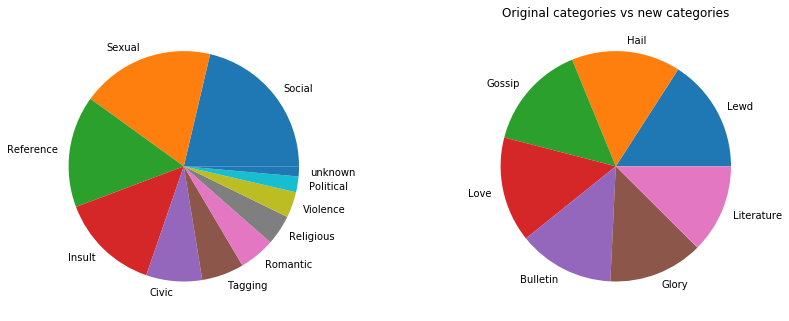

In [46]:
#Colors for new categories
colors_for_new_cats = ['green', 'yellow', 'purple', 'gray', 'blue', 'red', 'brown']

#Capture the values of the new categories to plot
v2cat_counts = df_clean['Category'].value_counts()

#Plot old categories side by side with new ones
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_axes([0, 0, .5, .5], aspect = 1)
ax1.pie(x = cat_counts, labels = cat_counts.index)
ax2 = fig.add_axes([0.5, 0, .5, .5], aspect = 1)
ax2.pie(x = v2cat_counts, labels = v2cat_counts.index)
#Need to fix title position
plt.title('Original categories vs new categories')
plt.show()

### MAKE THE COLORS CORRESPOND
Lavender   'Sexual', 'Love'
Brown   'Reference', 'Literature'
Yellow     'Insult', 'Hail'
Blue       'Civic', 'Bulletin'
Light blue 'Tagging', 'Bulletin'
Purple    'Romantic', 'Love'
Maroon    'Religious', 'Glory'
Red       'Violence', 'Glory'
Pink     'Political', 'Glory'
Dark blue  'unknown'], 'Bulletin'
Gray .      Social .     Gossip

Lewd  Green
Hail Yellow
Love Purple
Gossip Gray
Bulletin Blue
Glory Red
Literature Brown

In [ ]:
df_clean['Category'].value_counts()

Much better!

*Lewd*: Swear words and body parts

*Hail*: Hello, goodbye, bless you, curse you

*Love*: Romance & sex

*Gossip*: Have you heard who was drinking wine with Euphabia?

*Bulletin*: I baked bread today; I sold some pots today

*Glory*: The slaves won the battle! The emperor won the battle! The gods helped us win the battle!

*Literature*: Ovid, Aenid, Homer, Horace: we've got all the classics

Now let's see how this data performs with a plain vanilla logistic regression model.

### Another plain vanilla logistic regression with the new categories

In [40]:
#Prepare the data

df = copy.deepcopy(df_clean)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

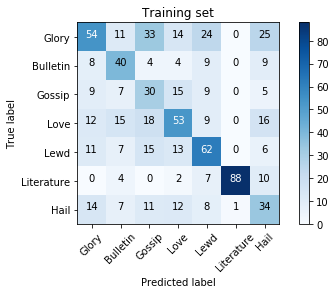

In [44]:
#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)

Fit the classifier to the training data
logreg.fit(X_train, y_train)

#Generate predicted y values for training set
y_hat_train = logreg.predict(X_train)

#Generate predicted y values for testing set
y_hat_test = logreg.predict(X_test)

#Create a confusion matrix for the training set
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix for the testing set
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)
#Draw a figure
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_train, title = 'Training set', classes = class_names)

In [42]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.34      0.50      0.40       108
   Bulletin       0.54      0.44      0.48        91
     Gossip       0.40      0.27      0.32       111
       Love       0.43      0.47      0.45       113
       Lewd       0.54      0.48      0.51       128
 Literature       0.79      0.99      0.88        89
       Hail       0.39      0.32      0.35       105

avg / total       0.48      0.48      0.48       745



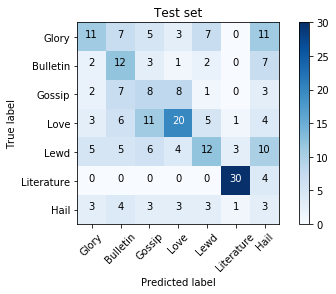

In [45]:
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_test, title = 'Test set', classes = class_names)

In [47]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

             precision    recall  f1-score   support

 Literature       0.25      0.42      0.31        26
      Glory       0.44      0.29      0.35        41
       Lewd       0.28      0.22      0.25        36
       Hail       0.40      0.51      0.45        39
   Bulletin       0.27      0.40      0.32        30
     Gossip       0.88      0.86      0.87        35
       Love       0.15      0.07      0.10        42

avg / total       0.38      0.39      0.37       249



The first model could only classify 3 out of 11 categories. The second model can classify all 7 of its categories, and it does a good job on 4 out of 7. Its accuracy is actually slightly lower than the first.

<a id = 'model1'></a>

[(Back to top)](#top)

# Modeling: Model \#1

<a id = 'model2'></a>

[(Back to top)](#top)

# Model \#2

## Decision trees

In [47]:
df = copy.deepcopy(df_clean)

Preparing the data:

In [93]:
class_names = set(df['Category'])

# Create label encoder instance
lb = LabelEncoder() 

# Create Numerical labels for categorical columns
df['Literacy_'] = lb.fit_transform(df['Literacy'])
df['Position_'] = lb.fit_transform(df['Position'])
df['Build_Type_'] = lb.fit_transform(df['Building Type'])
df['Famous_'] = lb.fit_transform(df['Famous House'])
df['Writer_'] = lb.fit_transform(df['Writer'])
df['Econ_Status_'] = lb.fit_transform(df['Socio-economic status'])
df['Imperative_'] = lb.fit_transform(df['Imperative'])
#the target
df['Category_'] = lb.fit_transform(df['Category'])

columns_to_encode = ['Literacy_', 'Position_', 'Build_Type_', 
                     'Famous_', 'Writer_', 'Econ_Status_', 
                     'Imperative_'
                    ]

columns_continuous = ['Reggio', 'Insula', 'Flohr Score', 
                      'Characters'
                     ]

# Split features and target variable
#X = df[columns_to_encode,]
y = df['Category_']

# Instantiate a one hot encoder
enc = OneHotEncoder()

# Fit the feature set X
enc.fit(df[columns_to_encode])

# Transform X's encoded columns to onehot array 
onehotX = enc.transform(df[columns_to_encode])

#Convert the sparse matrix back into a DF
X_onehot = pd.DataFrame(onehotX.todense())
#Get just the continuous columns
continuous = df[columns_continuous]
#Have to reset the index so the rows will line up with
#the rows in the encoded set
continuous.reset_index(inplace = True)
continuous.drop(['index'], axis = 1, inplace = True)

#Bring back together the encoded columns and the continuous columns
X = pd.concat([X_onehot, continuous], axis = 1)

# Create a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## A plain vanilla decision tree

In [49]:
# Train the classifier and make predictions
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train,y_train) 
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

### Visualize the result

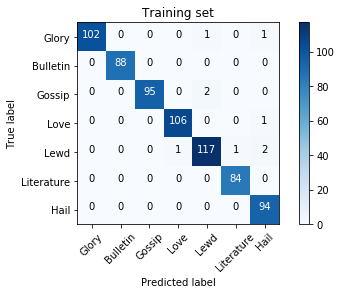

In [50]:
#Create confusion matrices with the results

class_names = set(df['Category'])

#A CM for the training set
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#A CM for the test set
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Draw the training CM
plot_conf_matrix(conf_matrix_train, title = 'Training set', classes = class_names)

In [51]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.98      1.00      0.99       102
   Bulletin       1.00      1.00      1.00        88
     Gossip       0.98      1.00      0.99        95
       Love       0.99      0.99      0.99       107
       Lewd       0.97      0.97      0.97       120
 Literature       1.00      0.99      0.99        85
       Hail       1.00      0.96      0.98        98

avg / total       0.99      0.99      0.99       695



Very over-fitted!

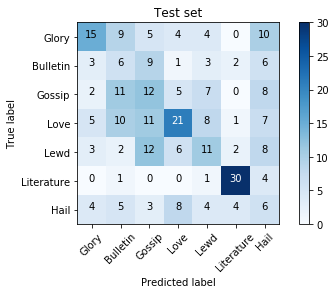

In [52]:
#Draw the test CM
plot_conf_matrix(conf_matrix_test, title = 'Test set', classes = class_names)

In [53]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.32      0.47      0.38        32
   Bulletin       0.20      0.14      0.16        44
     Gossip       0.27      0.23      0.25        52
       Love       0.33      0.47      0.39        45
       Lewd       0.25      0.29      0.27        38
 Literature       0.83      0.77      0.80        39
       Hail       0.18      0.12      0.14        49

avg / total       0.33      0.34      0.33       299



In [57]:
#Image = draw_graph(clf)

In looking at the graph I notice that X_54, 'Characters' appears again and again.

In [54]:
#MAybe useful for interpreting graph
print('Features:', clf.n_features_)
print('Tree depth:', clf.tree_.max_depth)
print('Nodes and leaves:', clf.tree_.node_count)
print('"Capacity":', clf.tree_.capacity)

Features: 55
Tree depth: 21
Nodes and leaves: 733
"Capacity": 733


Accuracy is lower than plain vanilla logistic regression. 

Decision tree is very complex.

Needs hyperparameter tuning.

What about with the gini coefficient instead?

In [55]:
DecisionTreeClassifier?

In [56]:
# Train the classifier and make predictions
clf = DecisionTreeClassifier(criterion = 'gini')
clf.fit(X_train,y_train) 
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

In [63]:
#Create confusion matrices with the results

class_names = set(df['Category'])

#A CM for the training set
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#A CM for the test set
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Draw the training CM
#plot_conf_matrix(conf_matrix_train, title = 'Training set', classes = class_names)

In [58]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.98      1.00      0.99       102
   Bulletin       1.00      1.00      1.00        88
     Gossip       0.98      1.00      0.99        95
       Love       0.99      0.99      0.99       107
       Lewd       0.97      0.97      0.97       120
 Literature       1.00      0.99      0.99        85
       Hail       1.00      0.96      0.98        98

avg / total       0.99      0.99      0.99       695



In [62]:
#Draw the test CM
#plot_conf_matrix(conf_matrix_test, title = 'Test set', classes = class_names)

In [60]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

             precision    recall  f1-score   support

      Glory       0.33      0.44      0.38        32
   Bulletin       0.26      0.20      0.23        44
     Gossip       0.17      0.15      0.16        52
       Love       0.36      0.44      0.40        45
       Lewd       0.22      0.26      0.24        38
 Literature       0.82      0.69      0.75        39
       Hail       0.18      0.14      0.16        49

avg / total       0.32      0.32      0.32       299



In [61]:
#MAybe useful for interpreting graph
print('Features:', clf.n_features_)
print('Tree depth:', clf.tree_.max_depth)
print('Nodes and leaves:', clf.tree_.node_count)
print('"Capacity":', clf.tree_.capacity)

Features: 55
Tree depth: 22
Nodes and leaves: 725
"Capacity": 725


Has just slightly lower accuracy scores and 10 fewer nodes than when measuring entropy.

## Building a df to store accuracy scores (on hold til I remember grid search)

In [122]:
#Build a generic dataframe to store precision, recall, and f1 of each decision tree classifier
score_columns = ['param_values', 'prec_train', 'prec_test', 
                                 'recall_train', 'recall_test', 
                                 'f1_train', 'f1_test']

score_df = pd.DataFrame(columns = score_columns)

In [105]:
#Testing for number of features

features_df = copy.deepcopy(score_df)
feature_params = [25, 30, 35, 40, 45, 50]
param = 25
for param in feature_params:
    features_df = features_df.append({'param_values': param}, ignore_index = True)

In [108]:
features_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,25.0,0.98825,0.345869,0.987582,0.346197,0.987819,0.343093
1,30.0,0.98825,0.335358,0.987582,0.336448,0.987819,0.330509
2,35.0,0.98825,0.349692,0.987582,0.353299,0.987819,0.347752
3,40.0,0.98825,0.348182,0.987582,0.359523,0.987819,0.346099
4,45.0,0.98825,0.325470,0.987582,0.327927,0.987819,0.323678
5,50.0,0.98825,0.324358,0.987582,0.338200,0.987819,0.325984


In [112]:
from sklearn import preprocessing

In [114]:
#This doesn't work super well
fx = features_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
fx_scaled = min_max_scaler.fit_transform(fx)
features_df_scaled = pd.DataFrame(fx_scaled)

In [115]:
features_df_scaled

,0,1,2,3,4,5,6
0,0.0,0.0,0.849093,0.0,0.578243,0.0,0.806471
1,0.2,0.0,0.434176,0.0,0.269689,0.0,0.283748
2,0.4,0.0,1.000000,0.0,0.802998,0.0,1.000000
3,0.6,0.0,0.940403,0.0,1.000000,0.0,0.931338
4,0.8,0.0,0.043882,0.0,0.000000,0.0,0.000000
5,1.0,0.0,0.000000,0.0,0.325132,0.0,0.095785


In [118]:
fx_scaled = preprocessing.scale(features_df)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [123]:
scaled_feature_df = pd.DataFrame(fx_scaled, columns = score_columns)
scaled_feature_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,-1.46385,0.0,0.739877,0.0,0.244006,0.0,0.707107
1,-0.87831,0.0,-0.268290,0.0,-0.671556,0.0,-0.581156
2,-0.29277,0.0,1.106553,0.0,0.910914,0.0,1.184063
3,0.29277,0.0,0.961745,0.0,1.495472,0.0,1.014843
4,0.87831,0.0,-1.216630,0.0,-1.471795,0.0,-1.280461
5,1.46385,0.0,-1.323255,0.0,-0.507041,0.0,-1.044397


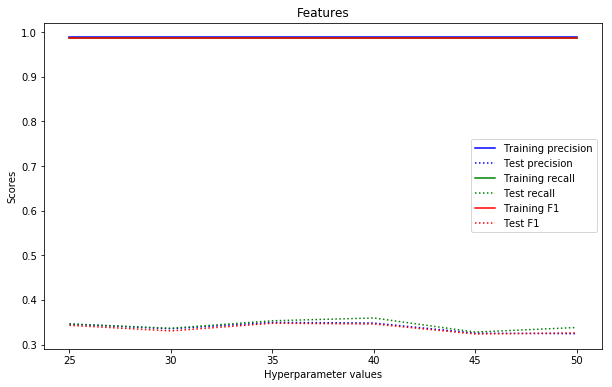

In [117]:
#Plot Hypers seems to be working
plot_hypers(features_df, 'Features')

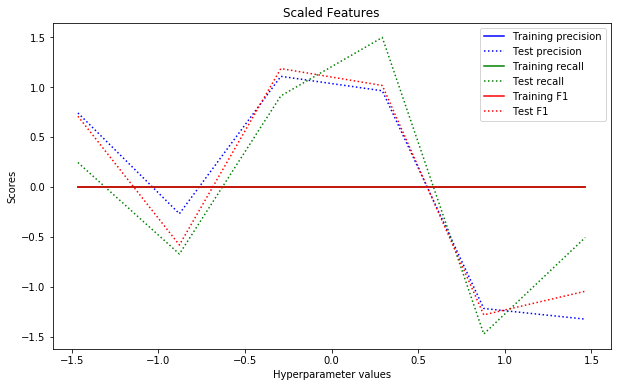

In [124]:
plot_hypers(scaled_feature_df, 'Scaled Features')

In [116]:

# Identify the optimal tree depth for given data
#max_depths = np.linspace(1, 32, 32, endpoint=True)
#train_results = []
#test_results = []
#for max_depth in max_depths:
#   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
#   dt.fit(x_train, y_train)
#   train_pred = dt.predict(x_train)
#   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#   roc_auc = auc(false_positive_rate, true_positive_rate)
#   # Add auc score to previous train results
##   train_results.append(roc_auc)
#   y_pred = dt.predict(x_test)
#   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#   roc_auc = auc(false_positive_rate, true_positive_rate)
#   # Add auc score to previous test results
#   test_results.append(roc_auc)
#plt.figure(figsize=(12,6))
#plt.plot(max_depths, train_results, 'b', label='Train AUC')
#plt.plot(max_depths, test_results, 'r', label='Test AUC')
#plt.ylabel('AUC score')
#plt.xlabel('Tree depth')
#plt.legend()
#plt.show()
def plot_hypers(df, title):
    '''
    A tool to
    
    '''
    # Number of iterations to plot along the x axis
    x = df['param_values']
   # tick_marks = np.arange(x.shape[0])
    #Draw a figure
    plt.figure(figsize=(10,6))
    
    plt.plot(x, df['prec_train'], 'b-', label = 'Training precision')
    plt.plot(x, df['prec_test'], 'b:', label = 'Test precision')
    plt.plot(x, df['recall_train'], 'g-', label = 'Training recall')
    plt.plot(x, df['recall_test'], 'g:', label = 'Test recall')
    plt.plot(x, df['f1_train'], 'r-', label = 'Training F1')
    plt.plot(x, df['f1_test'], 'r:', label = 'Test F1')
    #plt.xticks(tick_marks, x, rotation=45)
    plt.ylabel('Scores')
    plt.xlabel('Hyperparameter values')
    plt.title(title)
    plt.legend()
    plt.show()

In [98]:
def compare_hypers(df, index, X_train, X_test, y_train, y_test, 
                   criterion = 'entropy',
                   depth = None,
                   samples_split = 2,
                   samples_leaf = 1,
                   features = None,
                   leaf_nodes = None,
                   presort = False,
                  ):

    '''
    A tool to 
    '''
    
    #Instantiate a classifier with all default hyperparameters 
    #except whatever was passed
    clf = DecisionTreeClassifier(criterion = criterion,
                                 max_depth = depth,
                                 min_samples_split = samples_split,
                                 min_samples_leaf = samples_leaf,
                                 max_features = features,
                                 max_leaf_nodes = leaf_nodes,
                                 presort = presort
                                 )
   
    #Fit the data to the classifier
    clf.fit(X_train,y_train) 
    #Predict values for training data
    y_hat_train = clf.predict(X_train)
    #Predict values for testing data
    y_hat_test = clf.predict(X_test)

    #Get the scores
    prec_train = precision_score(y_train, y_hat_train, average = None).mean()
    prec_test = precision_score(y_test, y_hat_test, average = None).mean()
    recall_train = recall_score(y_train, y_hat_train, average = None).mean()
    recall_test =  recall_score(y_test, y_hat_test, average = None).mean()
    f1_train = f1_score(y_train, y_hat_train, average = None).mean()
    f1_test = f1_score(y_test, y_hat_test, average = None).mean()
    
    #Write the scores to the df
    df.at[index, 'prec_train'] = prec_train
    df.at[index, 'prec_test'] = prec_test
    df.at[index, 'recall_train'] = recall_train 
    df.at[index, 'recall_test'] = recall_test
    df.at[index, 'f1_train'] = f1_train
    df.at[index, 'f1_test'] = f1_test

<a id = 'model3'></a>

[(Back to top)](#top)

# Model \#3

In [ ]:
#Having reorganized the categories
#df = copy.deepcopy(df_raw)

<a id = 'model4'></a>

[(Back to top)](#top)

# Model \#4

<a id = 'concl'></a>

[(Back to top)](#top)

# Conclusions

In [ ]:
#df_raw[df_raw['In English'].str.contains('bake', regex = False, case = False)]
